In [1]:
import time,scipy,functools, gc
import numpy as np
import scipy.sparse.linalg as spla
from tfqmr import tfqmr
from quimb.utils import progbar as Progbar
from mpi4py import MPI
import ast

import scipy

# torch
from torch.nn.parameter import Parameter
import torch
import torch.nn as nn

# quimb
import quimb as qu
import quimb.tensor as qtn
import symmray as sr
import autoray as ar
from autoray import do


COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()
np.set_printoptions(suppress=True,precision=6,linewidth=100)


class fTNModel(torch.nn.Module):

    def __init__(self, ftn):
        super().__init__()
        # extract the raw arrays and a skeleton of the TN
        params, self.skeleton = qtn.pack(ftn)

        # Flatten the dictionary structure and assign each parameter
        self.torch_params = {
            tid: nn.ParameterDict({
                str(sector): nn.Parameter(data)
                for sector, data in blk_array.items()
            })
            for tid, blk_array in params.items()
        }

        # Get symmetry
        self.symmetry = ftn.arrays[0].symmetry

    

    def product_bra_state(self, config, peps, symmetry='Z2'):
        """Spinless fermion product bra state."""
        product_tn = qtn.TensorNetwork()
        backend = peps.tensors[0].data.backend
        iterable_oddpos = iter(range(2*peps.nsites+1))
        for n, site in zip(config, peps.sites):
            p_ind = peps.site_ind_id.format(*site)
            p_tag = peps.site_tag_id.format(*site)
            tid = peps.sites.index(site)
            nsites = peps.nsites
            # use autoray to ensure the correct backend is used
            with ar.backend_like(backend):
                if symmetry == 'Z2':
                    data = [sr.Z2FermionicArray.from_blocks(blocks={(0,):do('array', [1.0,], like=backend)}, duals=(True,),symmetry='Z2', charge=0, oddpos=2*tid+1), # It doesn't matter if oddpos is None for even parity tensor.
                            sr.Z2FermionicArray.from_blocks(blocks={(1,):do('array', [1.0,], like=backend)}, duals=(True,),symmetry='Z2',charge=1, oddpos=2*tid+1)
                        ]
                elif symmetry == 'U1':
                    data = [sr.U1FermionicArray.from_blocks(blocks={(0,):do('array', [1.0,], like=backend)}, duals=(True,),symmetry='U1', charge=0, oddpos=2*tid+1),
                            sr.U1FermionicArray.from_blocks(blocks={(1,):do('array', [1.0,], like=backend)}, duals=(True,),symmetry='U1', charge=1, oddpos=2*tid+1)
                        ]
            tsr_data = data[int(n)] # BUG: does not fit in jax compilation, a concrete value is needed for traced arrays
            tsr = qtn.Tensor(data=tsr_data, inds=(p_ind,),tags=(p_tag, 'bra'))
            product_tn |= tsr
        return product_tn

    def get_amp(self, peps, config, inplace=False, symmetry='Z2', conj=True):
        """Get the amplitude of a configuration in a PEPS."""
        if not inplace:
            peps = peps.copy()
        if conj:
            amp = peps|self.product_bra_state(config, peps, symmetry).conj()
        else:
            amp = peps|self.product_bra_state(config, peps, symmetry)
        for site in peps.sites:
            site_tag = peps.site_tag_id.format(*site)
            amp.contract_(tags=site_tag)

        amp.view_as_(
            qtn.PEPS,
            site_ind_id="k{},{}",
            site_tag_id="I{},{}",
            x_tag_id="X{}",
            y_tag_id="Y{}",
            Lx=peps.Lx,
            Ly=peps.Ly,
        )
        return amp
        
    def parameters(self):
        # Manually yield all parameters from the nested structure
        for tid_dict in self.torch_params.values():
            for param in tid_dict.values():
                yield param
    
    def from_params_to_vec(self):
        return torch.cat([param.data.flatten() for param in self.parameters()])
    
    @property
    def num_params(self):
        return len(self.from_params_to_vec())
    
    def params_grad_to_vec(self):
        param_grad_vec = torch.cat([param.grad.flatten() if param.grad is not None else torch.zeros_like(param).flatten() for param in self.parameters()])
        return param_grad_vec

    def clear_grad(self):
        for param in self.parameters():
            param.grad = None
    
    def from_vec_to_params(self, vec, quimb_format=False):
        # Reconstruct the original parameter structure (by unpacking from the flattened dict)
        params = {}
        idx = 0
        for tid, blk_array in self.torch_params.items():
            params[tid] = {}
            for sector, data in blk_array.items():
                shape = data.shape
                size = data.numel()
                if quimb_format:
                    params[tid][ast.literal_eval(sector)] = vec[idx:idx+size].view(shape)
                else:
                    params[tid][sector] = vec[idx:idx+size].view(shape)
                idx += size
        return params
    
    def load_params(self, new_params):
        if isinstance(new_params, torch.Tensor):
            new_params = self.from_vec_to_params(new_params)
        # Update the parameters manually
        with torch.no_grad():
            for tid, blk_array in new_params.items():
                for sector, data in blk_array.items():
                    self.torch_params[tid][sector].data = data

    
    def amplitude(self, x):
        # Reconstruct the original parameter structure (by unpacking from the flattened dict)
        params = {
            tid: {
                ast.literal_eval(sector): data
                for sector, data in blk_array.items()
            }
            for tid, blk_array in self.torch_params.items()
        }
        # Reconstruct the TN with the new parameters
        psi = qtn.unpack(params, self.skeleton)
       # `x` is expected to be batched as (batch_size, input_dim)
        # Loop through the batch and compute amplitude for each sample
        batch_amps = []
        for x_i in x:
            amp = self.get_amp(psi, x_i, symmetry=self.symmetry, conj=True)
            batch_amps.append(amp.contract())

        # Return the batch of amplitudes stacked as a tensor
        return torch.stack(batch_amps)
    
    def forward(self, x):
        if x.ndim == 1:
            # If input is not batched, add a batch dimension
            x = x.unsqueeze(0)
        return self.amplitude(x)



/home/sijingdu/anaconda3/envs/symmray_nqs/lib/python3.9/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [52]:
class VMC:
    """
    NOTE: At current stage, we consider only a 2D hamiltonianiltonian defined on a square lattice as the object function.
    1. Perform MC sampling from a parameterized probability distribution
    2. Compute the object function and quantities of interest (e.g. energy, gradient, etc.)
    3. Optimize the parameters of the probability distribution with respect to the object function using certain optimization algorithms
    
    """
    def __init__(
        self,
        hamiltonian,
        variational_state,
        optimizer,
        preconditioner=None,
        **kwargs,
    ):
        """
        Initializes the driver class.

        Args:
            hamiltonian: The Hamiltonian of the system.
            optimizer: Determines how optimization steps are performed given the
                bare energy gradient.
            variational_state: The variational state for which the hamiltonian must
                be minimised.
            preconditioner: Determines which preconditioner to use for the loss gradient.
                This must be a tuple of `(object, solver)` as documented in the section
                `preconditioners` in the documentation. The standard preconditioner
                included with NetKet is Stochastic Reconfiguration. By default, no
                preconditioner is used and the bare gradient is passed to the optimizer.
        """
        self._hamiltonian = hamiltonian # Use NetKet Hamiltonian object!
        
        self._state = variational_state # A variational state object: a torch function + sampler

        self._optimizer = optimizer

        self._preconditioner = preconditioner
        
    
    @property
    def preconditioner(self):
        """
        The preconditioner used to modify the gradient.

        This is a function with the following signature

        .. code-block:: python

            precondtioner(vstate: VariationalState,
                          grad: PyTree/vector,
                          step: Optional[Scalar] = None)

        Where the first argument is a variational state, the second argument
        is the PyTree/vector of the gradient to precondition and the last optional
        argument is the step, used to change some parameters along the
        optimisation.
        """
        return self._preconditioner
    

    def _forward_and_backward(self):
        """
        Performs a number of VMC optimization steps.

        Args:
            n_steps (int): Number of steps to perform.
        """

        self._state.reset() # Clear out the gradient of the state parameters

        # Compute the local energy estimator and average Energy
        self._loss_energy, self._loss_grad = self._state.expect_and_grad(self._ham)

        # if it's the identity it does
        # self._dp = self._loss_grad
        self._dp = self.preconditioner(self._state, self._loss_grad, self.step_count)
        # self._dp is the preconditioned gradient

        return self._dp

    @property
    def energy(self):
        """
        Aim: Return MCMC statistics for the expectation value of observables in the
        current state of the driver.

        Now: Return the energy of the current state.

        """
        return self._loss_energy

    def __repr__(self):
        return (
            "Vmc("
            + f"\n  step_count = {self.step_count},"
            + f"\n  state = {self._state})"
        )
    
    
    def run(self, start, stop, tmpdir=None): # Now naive implementation
        """Run the VMC optimization loop."""
        self.Einit = 0.
        Energy_stats_list = []
        for step in range(start, stop):
            # print('Variational step {}'.format(step))
            self.step = step
            # Compute the average energy and estimated energy gradient, meanwhile also record the amplitude_grad matrix
            # Use MPI for the sampling
            state_MC_energy, state_MC_energy_grad = self._state.expect_and_grad(self._hamiltonian)
            # Only rank 0 collects the energy statistics
            if RANK == 0:
                Energy_stats_list.append(state_MC_energy)
                print('Energy gradient vec: {}'.format(state_MC_energy_grad[:10]))
                # Precondition the gradient through SR
                preconditioned_grad = self.preconditioner(self._state, state_MC_energy_grad)
                # Compute the new parameter vector
                new_param_vec = self._optimizer.compute_update_params(self._state.params_vec, preconditioned_grad) # Subroutine: rank 0 computes new parameter vector based on the gradient
                # Broadcast the new parameter vector to all ranks
                self._state.reset() # Clear out the gradient of the state parameters
                print(state_MC_energy)
                print('Energy: {}'.format(state_MC_energy['mean']))
                new_param_vec = new_param_vec.detach().numpy()
            else:
                new_param_vec = None

            COMM.Bcast(new_param_vec,root=0)
            # Update the quantum state with the new parameter vector
            self._state.update_state(new_param_vec) # Reload the new parameter vector into the quantum state
            
        return Energy_stats_list
    

In [56]:
import scipy.linalg
from mpi4py import MPI
COMM = MPI.COMM_WORLD
SIZE = COMM.Get_size()
RANK = COMM.Get_rank()

class Variational_State:

    def __init__(self, vstate_func, sampler=None, hi=None):
        self.vstate_func = vstate_func
        self.sampler = sampler
        self.Np = vstate_func.num_params
        self.hi = sampler.hi if sampler is not None else hi
        self.Ns = sampler.Ns if sampler is not None else self.hi.n_states
        self.nsites = self.hi.size
        self.amp_grad_matrix = None
        assert self.hi is not None, "Hilbert space must be provided for sampling!"

    
    def reset(self):
        """Clear the gradient of the variational state."""
        self.vstate_func.clear_grad()

    def update_state(self, new_param_vec):
        """Update the variational state with the new parameter vector."""
        if not type(new_param_vec) == torch.Tensor:
            new_param_vec = torch.tensor(new_param_vec, dtype=torch.float32)
        self.vstate_func.load_params(new_param_vec)

    @property
    def params_vec(self):
        return self.vstate_func.from_params_to_vec()
    
    @property
    def params_grad_vec(self):
        return self.vstate_func.params_grad_to_vec()
    
    def amplitude(self, x):
        return self.vstate_func(x)
    
    def amplitude_grad(self, x):
        if not type(x) == torch.Tensor:
            x = torch.tensor(np.asarray(x), dtype=torch.float32)
        amp = self.vstate_func(x)
        amp.backward()
        vec_grad = self.vstate_func.params_grad_to_vec()
        # Clear the gradient
        self.reset()
        return amp, vec_grad

    def full_hi_amp_grad_matrix(self):
        """Construct the full Np x Ns matrix of amplitude gradients."""
        parameter_amp_grad = torch.zeros((self.Np, self.hi.n_states), dtype=torch.float32)
        all_config = self.hi.all_states()
        ampx_arr = torch.zeros((self.hi.n_states,), dtype=torch.float32)

        for i, config in enumerate(all_config):
            ampx, ampx_dp = self.amplitude_grad(config)
            parameter_amp_grad[:, i] = ampx_dp
            ampx_arr[i] = ampx

        return parameter_amp_grad, ampx_arr
    

    def get_amp_grad_matrix(self):
        """Return the amplitude gradient matrix."""
        if self.amp_grad_matrix is None:
            if self.sampler is None and self.hi is not None:
                return self.full_hi_amp_grad_matrix()
            else:
                raise ValueError("Sampler must be provided for sampling!")
        else:
            # should be computed during sampling
            return self.amp_grad_matrix
    

    def full_hi_expect_and_grad(self, op):
        """Full Hilbert space expectation value and gradient calculation.
        Only for sanity check on small systems.
        """
        hi = op.hilbert # netket hilbert object
        N = hi.size
        all_config = hi.all_states()
        psi = self.vstate_func(all_config)
        print(f'Psi: {psi[:10]}')
        psi = psi/do('linalg.norm', psi)
        
        op_dense = torch.tensor(op.to_dense(), dtype=torch.float32)
        expect_op = psi.conj().T@(op_dense@psi)

        expect_op.backward()
        vec_grad = self.vstate_func.params_grad_to_vec()
        # Clear the gradient
        self.reset()
        return {'mean': expect_op.detach().numpy()}, vec_grad
        
    
    def expect_and_grad(self, op, full_hi=False):
        """
        Compute the expectation value of the operator `op` and its gradient.

        Args:
            op (netket operator object): The operator for which the expectation value and gradient are calculated.
            full_hi (bool): Whether to use the full Hilbert space expectation value and gradient calculation.

        Returns:
            torch.tensor: The expectation value of the operator.
            torch.tensor: The gradient of the expectation value with respect to the parameters.
        """
        if full_hi or self.sampler is None:
            return self.full_hi_expect_and_grad(op)
        
        # use MPI for sampling
        chain_length = self.Ns//SIZE # Number of samples per rank

        op_expect, op_grad, op_var, op_error, config_list, amp_list = self.collect_samples(op, chain_length=chain_length)
        
        # return statistics of the MC sampling
        stats_dict = {'mean': op_expect, 'variance': op_var, 'error': op_error}


        return stats_dict, op_grad

    
    def collect_samples(self, op, chain_length=1):

        vstate = self

        print('RANK{}, sample size: {}, chain length: {}'.format(RANK, self.Ns, chain_length))
        
        # Sample on each rank
        # this should be a list of samples, where each sample is a tuple of (config, E_loc, amp, amp_grad)
        local_samples = self.sampler.sample(op, vstate, chain_length=chain_length)

        # Gather all samples to rank 0
        all_samples = COMM.gather(local_samples, root=0)
        # reset sampler
        self.sampler.reset()
        self.amp_grad_matrix = None

        if RANK == 0:
            # Join all samples list from all ranks into a single list
            # each sample is a tuple of (config, E_loc, amp, amp_grad)
            all_samples = [sample for sublist in all_samples for sample in sublist]

            op_loc = [sample[1] for sample in all_samples]
            amp_grad = [sample[3] for sample in all_samples]

            self.amp_grad_matrix = np.asarray(amp_grad).T

            # Compute the expectation value and gradient
            op_expect = np.mean(op_loc)
            mean_amp_grad = np.mean(amp_grad, axis=0)
            op_grad = np.mean([sample[1]*sample[3] for sample in all_samples], axis=0) - op_expect*mean_amp_grad

            config_list = [sample[0] for sample in all_samples]
            amp_list = [sample[2] for sample in all_samples]
            op_var = np.var(op_loc)
            op_error = np.sqrt(op_var/len(all_samples))

            return op_expect, op_grad, op_var, op_error, config_list, amp_list
        
        else:
            return None, None, None, None, None, None
        



import random

class Sampler:
    def __init__(self, hi, graph, N_samples=2**8, burn_in_steps=100):
        self.hi = hi
        self.Ns = N_samples
        self.graph = graph
        self.burn_in_steps = burn_in_steps
        self.initial_config = torch.tensor(np.asarray(random.choice(hi.all_states())), dtype=torch.float32)
        self.current_config = self.initial_config.clone()
    
    def reset(self):
        self.initial_config = torch.tensor(np.asarray(random.choice(self.hi.all_states())), dtype=torch.float32)
        self.current_config = self.initial_config.clone()

    def _sample_next(self, vstate_func):
        """Sample the next configuration."""
        raise NotImplementedError
    
    def sample(self, op, vstate, chain_length=1):
        """Sample the local energy and amplitude gradient for each configuration."""
        raise NotImplementedError
    
class MetropolisExchangeSampler(Sampler):
    def __init__(self, hi, graph, N_samples=2**8, burn_in_steps=100):
        super().__init__(hi, graph, N_samples, burn_in_steps)
    
    def burn_in(self, vstate):
        """Discard the initial samples. (Burn-in)"""
        for _ in range(self.burn_in_steps):
            self._sample_next(vstate)
    
    def _sample_next(self, vstate):
        """Sample the next configuration. Change the current configuration in place."""
        current_prob = abs(vstate.amplitude(self.current_config))**2
        proposed_config = self.current_config.clone()
        attempts = 0
        accepts = 0
        for (i, j) in self.graph.edges(): # We always loop over all edges.
            if self.current_config[i] == self.current_config[j]:
                continue
            attempts += 1
            proposed_config = self.current_config.clone()
            # swap the configuration on site i and j
            temp = proposed_config[i].item()
            proposed_config[i] = proposed_config[j]
            proposed_config[j] = temp
            proposed_prob = abs(vstate.amplitude(proposed_config))**2

            try:
                acceptance_ratio = proposed_prob/current_prob
            except ZeroDivisionError:
                acceptance_ratio = 1 if proposed_prob > 0 else 0

            if random.random() < acceptance_ratio:
                self.current_config = proposed_config
                current_prob = proposed_prob
                accepts += 1
        # print('Acceptance rate: {}'.format(accepts/attempts))
            
        return self.current_config
    
    def sample(self, op, vstate, chain_length=1):
        """Sample the local energy and amplitude gradient for each configuration."""
        self.burn_in(vstate)
        samples = []
        for _ in range(chain_length):
            sigma = self._sample_next(vstate)
            # compute local energy and amplitude gradient
            eta, O_etasigma = op.get_conn(sigma) # Non-zero matrix elements and corresponding configurations
            psi_sigma, psi_sigma_grad = vstate.amplitude_grad(sigma)
            psi_eta = vstate.amplitude(eta)

            psi_sigma = psi_sigma.detach().numpy()
            psi_eta = psi_eta.detach().numpy()
            psi_sigma_grad = psi_sigma_grad.detach().numpy()

            O_loc = np.sum(O_etasigma * (psi_eta / psi_sigma), axis=-1)
            samples.append((sigma.detach().numpy(), O_loc, psi_sigma, psi_sigma_grad))

        return samples


    

class Preconditioner:
    def __call__(self, state, grad):
        """Abstract method for preconditioning the gradient."""
        
        raise NotImplementedError

class TrivialPreconditioner(Preconditioner):
    """Trivial preconditioner that does nothing."""
    def __call__(self, state, grad):
        return grad

class SR(Preconditioner):
    """
    Math: S*dp = g, where S is the QGT and g is the energy gradient. dp is the preconditioned gradient.
    g = <E_loc(x)*O(x)> - <E_loc(x)>*<O(x)>, where O(x) = \nabla_{\theta} log(psi(x;\theta)) is the gradient of the log amplitude.
    O(x) has shape of (Np,), where Np is the number of parameters.

    S = <O^\dagger(x)*O(x)> - <O^\dagger(x)>*<O(x)>, which has shape of (Np, Np).
    S is a positive definite matrix.
    S can be computed from the amp_grad matrix, which has shape of (Np, Ns), where Ns is the number of samples.
    S is just the covariance matrix of the amp_grad vectors.

    In practice, one does not need to compute the dense S matrix to solve for dp.
    One can solve the linear equation S*dp = g iteratively using scipy.sparse.linalg.
    """
    def __init__(self, dense=False, iter_step=None, exact=False):
        self.dense = dense
        self.iter_step = iter_step
        self.exact = exact
    def __call__(self, state, energy_grad, eta=1e-3):
        """iter_step is for iterative solvers."""
        if self.exact:
            parameter_amp_grad, amp_arr = state.get_amp_grad_matrix()
            parameter_amp_grad = parameter_amp_grad.detach().numpy()
            amp_arr = amp_arr.detach().numpy()
            norm_sqr = np.linalg.norm(amp_arr)**2
            S = np.sum([np.outer(amp_grad, amp_grad.conj()) for amp_grad in parameter_amp_grad.T], axis=0)/norm_sqr
            weighted_amp_grad = np.sum([amp_arr[i]*parameter_amp_grad[:, i] for i in range(amp_arr.shape[0])], axis=0)/norm_sqr
            S -= np.outer(weighted_amp_grad, weighted_amp_grad.conj())
            R = S + eta*np.eye(S.shape[0])
            dp = scipy.linalg.solve(R, energy_grad.detach().numpy())
            return torch.tensor(dp, dtype=torch.float32)

        amp_grad_matrix_normalized = state.get_amp_grad_matrix()
        if type(amp_grad_matrix_normalized) is torch.Tensor:
            amp_grad_matrix_normalized = amp_grad_matrix_normalized.detach().numpy()
        if self.dense:
            # form the dense S matrix
            S = np.mean([np.outer(amp_grad, amp_grad.conj()) for amp_grad in amp_grad_matrix_normalized.T], axis=0)
            S -= amp_grad_matrix_normalized.mean(axis=1)@amp_grad_matrix_normalized.mean(axis=1).T
            R = S + eta*np.eye(S.shape[0])
            dp = scipy.linalg.solve(R, energy_grad)
            return torch.tensor(dp, dtype=torch.float32)



import torch_optimizer
import torch.optim as optim

class Optimizer:
    def __init__(self, learning_rate=1e-3):
        self.lr = learning_rate
    
    def compute_update_params(self, params, grad):
        raise NotImplementedError

class SGD(Optimizer):
    def __init__(self, learning_rate=1e-3):
        super().__init__(learning_rate)
    
    def compute_update_params(self, params, grad):
        return params - self.lr*grad

class SignedSGD(Optimizer):
    def __init__(self, learning_rate=1e-3):
        super().__init__(learning_rate)
    
    def compute_update_params(self, params, grad):
        if type(grad) != torch.Tensor:
            grad = torch.tensor(grad, dtype=torch.float32)
        return params - self.lr*torch.sign(grad)

class SignedRandomSGD(Optimizer):
    def __init__(self, learning_rate=1e-3):
        super().__init__(learning_rate)
    
    def compute_update_params(self, params, grad):
        return params - self.lr*torch.sign(grad)*torch.rand(1)

# Experiment

In [58]:
from fermion_utils import *
# import flax.linen as nn
# from flax.core import FrozenDict
# from flax import traverse_util
import netket as nk
import netket.experimental as nkx
import netket.nn as nknn

from math import pi

from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc

# Define the lattice shape
L = 4  # Side of the square
Lx = int(L)
Ly = int(L/2)
# graph = nk.graph.Square(L)
graph = nk.graph.Grid([Lx,Ly], pbc=False)
N = graph.n_nodes


# Define the fermion filling and the Hilbert space
N_f = int(Lx*Ly/2-1)
hi = nkx.hilbert.SpinOrbitalFermions(N, s=None, n_fermions=N_f)


# Define the Hubbard Hamiltonian
t = 1.0
V = 4.0
H = 0.0
for (i, j) in graph.edges(): # Definition of the Hubbard Hamiltonian
    H -= t * (cdag(hi,i) * c(hi,j) + cdag(hi,j) * c(hi,i))
    H += V * nc(hi,i) * nc(hi,j)


# Exact diagonalization of the Hamiltonian for benchmark
sp_h = H.to_sparse() # Convert the Hamiltonian to a sparse matrix
from scipy.sparse.linalg import eigsh
eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")
E_gs = eig_vals[0]
print("Exact ground state energy per site:", E_gs)

Exact ground state energy per site: -3.1891064523138195


In [14]:
# SU in quimb
Lx = int(L)
Ly = int(L/2)
D = 4
seed = 2
symmetry = 'U1'
peps, parity_config = generate_random_fpeps(Lx, Ly, D, seed, symmetry, Nf=N_f)

edges = qtn.edges_2d_square(Lx, Ly)
site_info = sr.utils.parse_edges_to_site_info(
    edges,
    D,
    phys_dim=2,
    site_ind_id="k{},{}",
    site_tag_id="I{},{}",
)

t = 1.0
V = 4.0
mu = 0.0

terms = {
    (sitea, siteb): sr.fermi_hubbard_spinless_local_array(
        t=t, V=V, mu=mu,
        symmetry=symmetry,
        coordinations=(
            site_info[sitea]['coordination'],
            site_info[siteb]['coordination'],
        ),
    ).fuse((0, 1), (2, 3))
    for (sitea, siteb) in peps.gen_bond_coos()
}
ham = qtn.LocalHam2D(Lx, Ly, terms)
su = qtn.SimpleUpdateGen(peps, ham, compute_energy_per_site=True,D=D, compute_energy_opts={"max_distance":2}, gate_opts={'cutoff':1e-12})

# cluster energies may not be accuracte yet
su.evolve(5, tau=0.3)
# su.evolve(50, tau=0.1)
# su.evolve(100, tau=0.03)
# su.evolve(100, tau=0.01)
# su.evolve(100, tau=0.003)

peps = su.get_state()
peps.equalize_norms_(value=1)


n=5, tau=0.3000, energy~-0.347505: 100%|##########| 5/5 [00:00<00:00, 23.07it/s]


fPEPS(tensors=8, indices=18, Lx=4, Ly=2, max_bond=4)

In [15]:
import torch
import torch.nn as nn

ham = qtn.LocalHam2D(Lx, Ly, terms)
def convert_to_torch(blk_arr):
    new_blks = { sector: torch.tensor(blk, dtype=torch.float32) for sector, blk in blk_arr.blocks.items() }
    new_blk_arr = blk_arr.copy_with(blocks=new_blks)
    return new_blk_arr

ham.apply_to_arrays(lambda x: convert_to_torch(x))
peps.apply_to_arrays(lambda x: torch.tensor(x, dtype=torch.float32))


VMC

In [57]:
model = fTNModel(peps)

optimizer = SignedSGD(learning_rate=5e-3)
sampler = None
# sampler = MetropolisExchangeSampler(hi, graph, N_samples=64, burn_in_steps=10)
variational_state = Variational_State(model, hi=H.hilbert, sampler=sampler)
# preconditioner = SR(dense=True, exact=True if sampler is None else False)
preconditioner = TrivialPreconditioner()

vmc = VMC(H, variational_state, optimizer, preconditioner)

stats = vmc.run(0, 15)

# import torch_optimizer

# optimizer = torch_optimizer.AdaBelief(model.parameters(), lr=0.01)

# test_sample = sampler._sample_next(variational_state)
# type(H.get_conn(test_sample)[0][0])
# sample0 = sampler.sample(H, variational_state, chain_length=4)

Psi: tensor([ 4.4230e-04,  2.4416e-05, -1.3158e-03, -1.7969e-04,  1.4897e-03,
         5.0495e-05, -1.7490e-04,  4.3562e-03,  4.7546e-04,  4.9765e-04],
       grad_fn=<SliceBackward0>)
Energy gradient vec: tensor([-0.3672, -0.4275, -0.0481,  0.3924,  0.1809, -0.1320, -0.2535, -0.3278,
        -0.0508,  0.0270])
{'mean': array(-2.760063, dtype=float32)}
Energy: -2.7600629329681396
Psi: tensor([ 3.7488e-04,  2.4436e-05, -1.2140e-03, -2.0670e-04,  1.3459e-03,
         1.2477e-04, -1.8591e-04,  4.3067e-03,  5.8222e-04,  5.4728e-04],
       grad_fn=<SliceBackward0>)
Energy gradient vec: tensor([-0.2244, -0.3170,  0.0192,  0.3386,  0.1675, -0.0943, -0.1642, -0.2839,
        -0.0350,  0.0244])
{'mean': array(-2.888835, dtype=float32)}
Energy: -2.8888354301452637
Psi: tensor([ 3.1297e-04,  2.1228e-05, -1.1100e-03, -2.2095e-04,  1.1779e-03,
         1.9866e-04, -1.7651e-04,  4.1155e-03,  6.6870e-04,  5.5198e-04],
       grad_fn=<SliceBackward0>)
Energy gradient vec: tensor([-0.1227, -0.2343,  0

KeyboardInterrupt: 

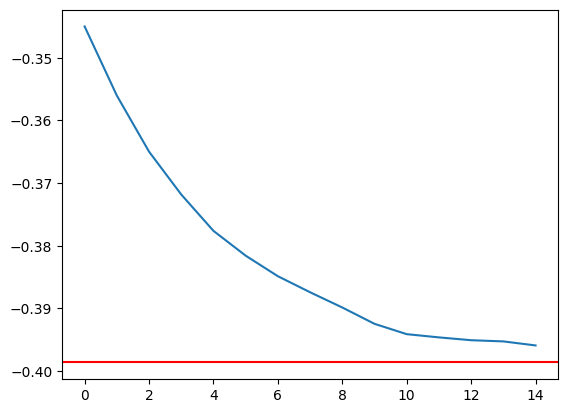

In [44]:
# plot
import matplotlib.pyplot as plt
plt.plot([stat['mean']/graph.n_nodes for stat in stats])
# plot exact gs energy
plt.axhline(y=E_gs/N, color='r', linestyle='-')
plt.show()

In [382]:
grad_vec = variational_state.expect_and_grad(H)[1]

RANK0, sample size: 20, chain length: 20
Total number of samples: 20


In [388]:
# show more precision
np.set_printoptions(suppress=True,precision=6,linewidth=100)
print(grad_vec)

[ 0.000418 -0.000124  0.000083 -0.000016  0.000011 -0.000373 -0.000299  0.000049 -0.000012
  0.000023  0.000498 -0.000179 -0.000014 -0.000297 -0.000041  0.000045 -0.000005  0.000217
 -0.000016  0.000028 -0.000039 -0.000005  0.000305  0.000043 -0.000018 -0.000021 -0.000011
 -0.000013  0.000007 -0.000003  0.000002 -0.000001 -0.000855  0.000004 -0.000253  0.000077
 -0.000275  0.000023 -0.000154  0.000036 -0.000234  0.000031  0.000153  0.000012  0.000388
  0.000075 -0.000156 -0.000026 -0.000032 -0.000037  0.000006  0.000008  0.000023 -0.000011
  0.000014 -0.000007  0.000299 -0.00005   0.000008  0.000004 -0.000017  0.000004  0.000029
 -0.000004  0.000016 -0.000002 -0.000912  0.00036   0.000027 -0.000018 -0.000261  0.000009
 -0.000216  0.000049 -0.000034  0.000004 -0.000019  0.000002  0.000106 -0.000006  0.000003
 -0.        0.       -0.000013  0.000003 -0.000047  0.000056 -0.000012 -0.00054   0.000082
  0.000272 -0.00004   0.000042  0.000002  0.        0.000002  0.000001  0.        0.
 -0.0